# Autoencoders

In this notebook we implement a vanilla autoencoder using the MNIST dataset and PyTorch. 

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
# hyperparameters
BATCH_SIZE = 64
LR = 0.0001
NUM_EPOCHS = 20
DEVICE = torch.device('cuda')

We use a single `Module` to for the implementation of the encoder and the decoder. Theoretically we could implment both in a single `Sequential` model, but we would like to keep the encoder and the decoder separately, as this will allow us in a later step to use the decoder to generate new digits. We use the `sigmoid` activation function in the decoder, because our images are scaled between the values 0 and 1 after we use the `ToTensor` transform from torchvision.


We start out with images of size 28x28 and compress the information that is contained in the image into a single 10 dimensional vector.

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=1600, out_features=10)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=10, out_features=1600),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (64, 5, 5)),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Our `train` and `track_performance` functions are very similar to those we have implemented in the previous sections. We implement the training loop and evaluate the performance.

In [4]:
def train(num_epochs, train_dataloader, val_dataloader, model, criterion, optimizer, scheduler=None):
    history = {"train_loss": [], "val_loss": []}
    model.to(DEVICE)
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, _) in enumerate(train_dataloader):
            model.train()
            features = features.to(DEVICE)
            
            # Empty the gradients
            optimizer.zero_grad()
            
            # Forward Pass
            output = model(features)
            
            # Calculate Loss
            loss = criterion(output, features)
            
            # Backward Pass
            loss.backward()
            
            # Gradient Descent
            optimizer.step()
            
        train_loss = track_performance(train_dataloader, model, criterion)
        val_loss = track_performance(val_dataloader, model, criterion)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f'Epoch: {epoch+1:>2}/{num_epochs} | Train Loss: {train_loss:.7f} | Val Loss: {val_loss:.7f}')
        
        if scheduler:
            scheduler.step(val_loss)

In [5]:
def track_performance(dataloader, model, criterion):
    # switch to evaluation mode
    model.eval()
    num_samples = 0
    loss_sum = 0
    
    # no need to calculate gradients
    with torch.inference_mode():
        for batch_idx, (features, _) in enumerate(dataloader):
            features = features.to(DEVICE)
            output = model(features)
            loss = criterion(output, features)
            loss_sum += loss.cpu().item()
            num_samples += len(features)
    
    # we return the average loss
    return loss_sum/num_samples

In [6]:
train_dataset = MNIST(root='../datasets/', transform=transforms.ToTensor(), train=True, download=True)
val_dataset = MNIST(root='../datasets/', transform=transforms.ToTensor(), train=False, download=False)

In [7]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)

In [8]:
autoencoder = Autoencoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=LR)
criterion = nn.MSELoss(reduction='mean')

In [9]:
train(NUM_EPOCHS, train_dataloader, val_dataloader, autoencoder, criterion, optimizer)

Epoch:  1/20 | Train Loss: 0.0007112 | Val Loss: 0.0007060
Epoch:  2/20 | Train Loss: 0.0004671 | Val Loss: 0.0004614
Epoch:  3/20 | Train Loss: 0.0004086 | Val Loss: 0.0004029
Epoch:  4/20 | Train Loss: 0.0003847 | Val Loss: 0.0003796
Epoch:  5/20 | Train Loss: 0.0003706 | Val Loss: 0.0003664
Epoch:  6/20 | Train Loss: 0.0003528 | Val Loss: 0.0003493
Epoch:  7/20 | Train Loss: 0.0003435 | Val Loss: 0.0003400
Epoch:  8/20 | Train Loss: 0.0003338 | Val Loss: 0.0003310
Epoch:  9/20 | Train Loss: 0.0003248 | Val Loss: 0.0003219
Epoch: 10/20 | Train Loss: 0.0003177 | Val Loss: 0.0003157
Epoch: 11/20 | Train Loss: 0.0003149 | Val Loss: 0.0003125
Epoch: 12/20 | Train Loss: 0.0003078 | Val Loss: 0.0003061
Epoch: 13/20 | Train Loss: 0.0003045 | Val Loss: 0.0003023
Epoch: 14/20 | Train Loss: 0.0002985 | Val Loss: 0.0002973
Epoch: 15/20 | Train Loss: 0.0002941 | Val Loss: 0.0002931
Epoch: 16/20 | Train Loss: 0.0002906 | Val Loss: 0.0002893
Epoch: 17/20 | Train Loss: 0.0002861 | Val Loss: 0.00028

The results look good, but are somewhat blurry. This is actually quite common for autoencoders, especially considering that we compressed a 28*28 image to a vector of size 10.

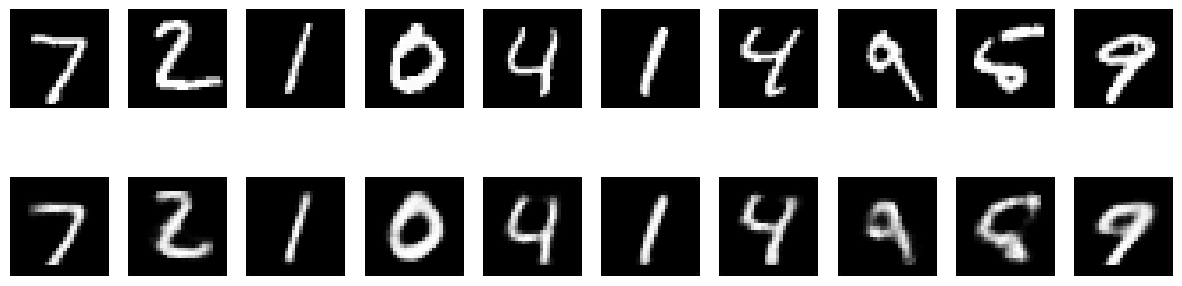

In [10]:
# draw original and reconstructed images
batch, _ = next(iter(val_dataloader))
batch = batch[:10, ...]
fig = plt.figure(figsize=(15, 4))

with torch.inference_mode():
    for i, img in enumerate(batch):
        fig.add_subplot(2, 10, i+1)
        orig_img = img.numpy()[0]
        plt.imshow(orig_img, cmap="gray")
        plt.axis('off')
        
        fig.add_subplot(2, 10, i+1+10)
        img = img.unsqueeze(0).to(DEVICE)
        rec_img = autoencoder(img).squeeze().cpu().numpy()
        plt.imshow(rec_img, cmap="gray")
        plt.axis('off')

    plt.show()